In [1]:
import cv2
import yaml
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.nn import functional as F

import onnx
import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

## Export an ONNX model
#### 모델 불러오기 - MIRNetv2

In [2]:
from basicsr.models.archs.mirnet_v2_arch import MIRNet_v2
try:
    from yaml import CLoader as Loader
except ImportError:
    from yaml import Loader

#* config & pretrained-weight 경로 설정
yaml_file  = './Enhancement/Options/Enhancement_MIRNet_v2_FiveK.yml'  # config 경로
weights  = 'pretrained_models/enhancement_fivek.pth'     # 모델 가중치 경로

#* model 불러오기
x = yaml.load(open(yaml_file, mode='r'), Loader=Loader)
s = x['network_g'].pop('type')
model_restoration = MIRNet_v2(**x['network_g'])
checkpoint = torch.load(weights)
model_restoration.load_state_dict(checkpoint['params'])

model_restoration.cuda()

model_restoration.eval()

print("===>Testing using weights: ",weights)
print('모델 로딩 완')

===>Testing using weights:  pretrained_models/enhancement_fivek.pth
모델 로딩 완


##### 모델 작동 여부 확인 및 input 값 체크

In [3]:
import Enhancement.utils as utils

factor = 4

img = np.float32(utils.load_img('demo/restored/real_denoising/1.png'))/255.
img = cv2.resize(img, (512, 512))
img = torch.from_numpy(img).permute(2,0,1)
input_ = img.unsqueeze(0)
# Padding in case images are not multiples of 4
h,w = input_.shape[2], input_.shape[3]
H,W = ((h+factor)//factor)*factor, ((w+factor)//factor)*factor
padh = H-h if h%factor!=0 else 0
padw = W-w if w%factor!=0 else 0
input_ = F.pad(input_, (0,padw,0,padh), 'reflect').cuda()

restored = model_restoration(input_)

#### onnx 변환

In [3]:
# onnx 모델 저장 경로
onnx_model_path = './onnx_models/MIRNetv2_gpu_softmax.onnx'
device    = torch.device('cuda')
dummy_inputs = {
    "input" : torch.as_tensor(np.ones([1, 3, 256, 256]), dtype = torch.float32).to(device)
}
output_names = ["output"]

torch.onnx.export(
        model=model_restoration,                            # 실행될 모델
        args = tuple(dummy_inputs.values()),        # 모델 입력값(tuple or 여러 입력값)
        f = onnx_model_path,                     # 모델 저장 경로
        export_params=True,                 # 모델 파일 안에 학습된 모델 가중치 저장 여부
        opset_version=13,                   # 모델 변환할 때 사용할 onnx 버전
        do_constant_folding = True,         # 최적화시 상수폴딩 사용할지 여부
        input_names=list(dummy_inputs.keys()),
        output_names=output_names,
        dynamic_axes={
            'input'     : {0 : 'batch_size'},    # 가변적인 길이를 가진 차원
            'output'    : {0 : 'batch_size'}
        }
    ) 

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [4]:
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)
print('The ONNX model  is valid')
print(onnx.helper.printable_graph(onnx_model.graph))

The ONNX model  is valid
graph torch_jit (
  %input[FLOAT, batch_sizex3x256x256]
) initializers (
  %conv_in.weight[FLOAT, 80x3x3x3]
  %body.0.body.0.dau_top.body.0.weight[FLOAT, 80x80x3x3]
  %body.0.body.0.dau_top.body.2.weight[FLOAT, 80x80x3x3]
  %body.0.body.0.dau_top.gcnet.conv_mask.weight[FLOAT, 1x80x1x1]
  %body.0.body.0.dau_top.gcnet.channel_add_conv.0.weight[FLOAT, 80x80x1x1]
  %body.0.body.0.dau_top.gcnet.channel_add_conv.2.weight[FLOAT, 80x80x1x1]
  %body.0.body.0.dau_mid.body.0.weight[FLOAT, 120x120x3x3]
  %body.0.body.0.dau_mid.body.2.weight[FLOAT, 120x120x3x3]
  %body.0.body.0.dau_mid.gcnet.conv_mask.weight[FLOAT, 1x120x1x1]
  %body.0.body.0.dau_mid.gcnet.channel_add_conv.0.weight[FLOAT, 120x120x1x1]
  %body.0.body.0.dau_mid.gcnet.channel_add_conv.2.weight[FLOAT, 120x120x1x1]
  %body.0.body.0.dau_bot.body.0.weight[FLOAT, 180x180x3x3]
  %body.0.body.0.dau_bot.body.2.weight[FLOAT, 180x180x3x3]
  %body.0.body.0.dau_bot.gcnet.conv_mask.weight[FLOAT, 1x180x1x1]
  %body.0.body.0

#### ONNX 모델 양자화

In [5]:
onnx_model_quantized_path = "./onnx_models/mirnet_sh.onnx"
quantize_dynamic(
    model_input=onnx_model_path,
    model_output=onnx_model_quantized_path,
    #optimize_model=True,
    per_channel=False,
    reduce_range=False,
    weight_type=QuantType.QUInt8,
)
#onnx_model_path = onnx_model_quantized_path

Ignore MatMul due to non constant B: /[/body/body.0/body/body.0/dau_top/gcnet/MatMul]
Ignore MatMul due to non constant B: /[/body/body.0/body/body.0/dau_mid/gcnet/MatMul]
Ignore MatMul due to non constant B: /[/body/body.0/body/body.0/dau_bot/gcnet/MatMul]
Ignore MatMul due to non constant B: /[/body/body.0/body/body.0/dau_top/gcnet_1/MatMul]
Ignore MatMul due to non constant B: /[/body/body.0/body/body.0/dau_mid/gcnet_1/MatMul]
Ignore MatMul due to non constant B: /[/body/body.0/body/body.0/dau_bot/gcnet_1/MatMul]
Ignore MatMul due to non constant B: /[/body/body.0/body/body.1/dau_top/gcnet/MatMul]
Ignore MatMul due to non constant B: /[/body/body.0/body/body.1/dau_mid/gcnet/MatMul]
Ignore MatMul due to non constant B: /[/body/body.0/body/body.1/dau_bot/gcnet/MatMul]
Ignore MatMul due to non constant B: /[/body/body.0/body/body.1/dau_top/gcnet_1/MatMul]
Ignore MatMul due to non constant B: /[/body/body.0/body/body.1/dau_mid/gcnet_1/MatMul]
Ignore MatMul due to non constant B: /[/body

## Test - Using an ONNX model

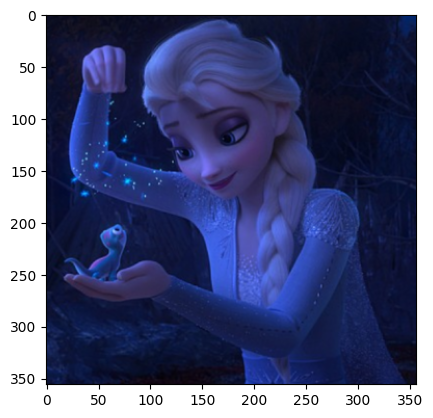

In [6]:
# test 이미지
import Enhancement.utils as utils

factor = 4

img = np.float32(utils.load_img('disney01.png'))/255
img = cv2.resize(img, (356, 356))
plt.imshow(img)
img = torch.from_numpy(img).permute(2,0,1)
input_ = img.unsqueeze(0)
# Padding in case images are not multiples of 4
h,w = input_.shape[2], input_.shape[3]
H,W = ((h+factor)//factor)*factor, ((w+factor)//factor)*factor
padh = H-h if h%factor!=0 else 0
padw = W-w if w%factor!=0 else 0
input_ = F.pad(input_, (0,padw,0,padh), 'reflect')

# loading
ort_session = onnxruntime.InferenceSession(onnx_model_quantized_path, providers=['AzureExecutionProvider'])

image_embedding = input_.detach().cpu().numpy()

# 테스트 실행
ort_inputs  = {ort_session.get_inputs()[0].name : image_embedding}
ort_outputs = ort_session.run(None, ort_inputs)

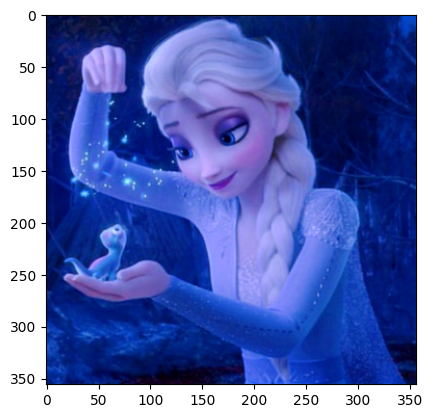

In [7]:
from PIL import Image
from skimage import img_as_ubyte
ort_output = torch.tensor(ort_outputs[0])
final_output = torch.clamp(ort_output,0,1).cpu().detach().permute(0, 2, 3, 1).squeeze(0).numpy()

utils.save_img('./disney01_result.png', img_as_ubyte(final_output))
plt.imshow(final_output)
